# 1. Introduction
The goal of this kernel is to build CNN models to classify bees images by their subspecies.

In [1]:
# Let's import the library we will be using
import pandas as pd
import numpy as np
import sys
import os
import random
from pathlib import Path
import math

import imageio
import skimage
import skimage.io
import skimage.transform

from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
from sklearn.model_selection import train_test_split
from sklearn import metrics

from keras import optimizers
from keras import Model
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization,LeakyReLU, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras.utils import to_categorical
from keras.applications import xception
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.models import load_model

# Setting the seeds
np.random.seed(42)
tf.random.set_seed(42)


In [2]:
# Defining our constants 
IMAGE_WIDTH = 100
IMAGE_HEIGHT = 100
IMAGE_CHANNELS = 3

RANDOM_STATE = 24
BATCH_SIZE = 32
PATIENCE = 5
VERBOSE = 1

# 2. Exploring the data

In [3]:
# Let's load and take a look at the csv
bees_df = pd.read_csv('../input/honey-bee-annotated-images/bee_data.csv', parse_dates={'datetime':[1,2]}, index_col=False,)
print(bees_df.shape)
bees_df.head()

(5172, 8)


,datetime,file,location,zip code,subspecies,health,pollen_carrying,caste
0,2018-08-28 16:07:00,041_066.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
1,2018-08-28 16:07:00,041_072.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
2,2018-08-28 16:07:00,041_073.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
3,2018-08-28 16:07:00,041_067.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
4,2018-08-28 16:07:00,041_059.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker


In [4]:
# Drop missing data
bees_df.dropna(inplace=True)

In [5]:
# Let's now take a look at the images
IMAGES_PATH = '../input/honey-bee-annotated-images/bee_imgs/bee_imgs/'
image_files = os.listdir(IMAGES_PATH)
print('Sample:', image_files[:5])
print('Image count: ',len(image_files))

Sample: ['032_339.png', '019_321.png', '039_014.png', '015_1169.png', '040_409.png']
Image count:  5172


In [6]:
# Check if there are bees that share the same image file
print("Are there any duplicate image files:", bees_df['file'].duplicated().any())

# Check if all filenames in the dataset exists
print("Does all filepath from the dataset exist:", set(image_files) == set(bees_df['file']))

Are there any duplicate image files: False
Does all filepath from the dataset exist: True


In [7]:
# Remove bees that do not have images
bees_df = bees_df[bees_df['file'].isin(image_files)] 

Now that we have the data, let's see what type of insight we can get from exploring it.

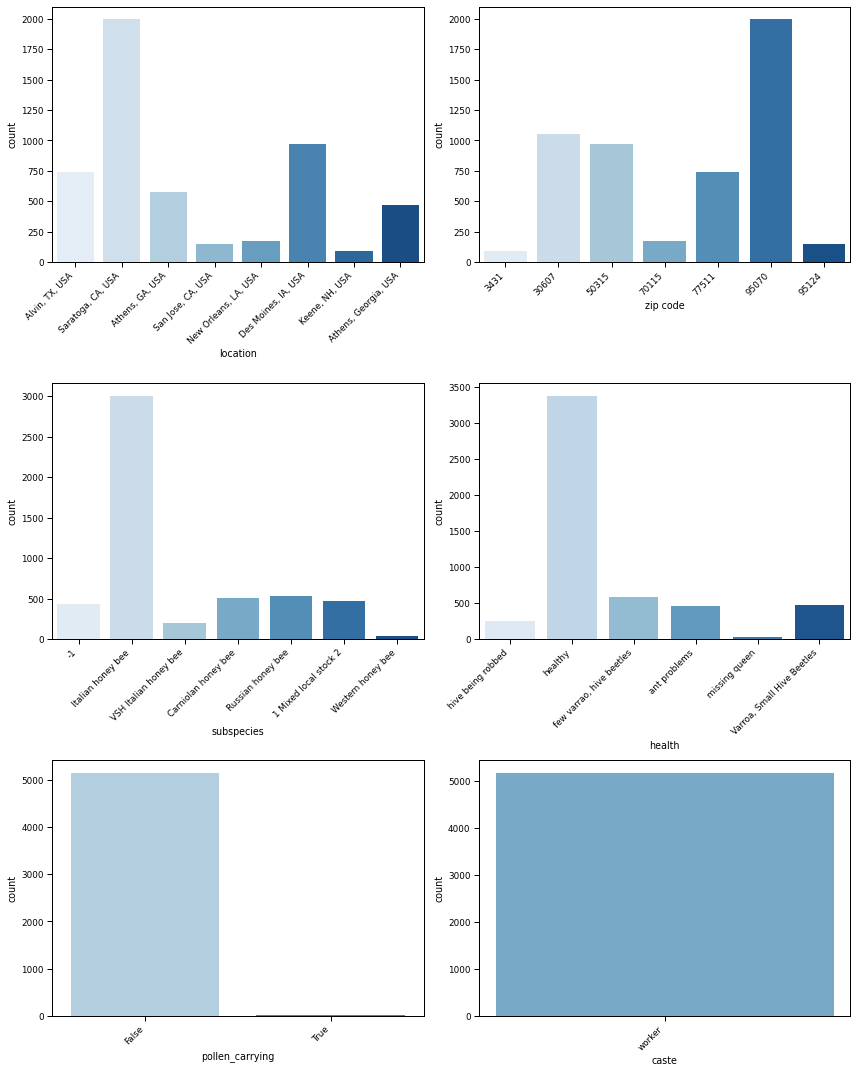

In [8]:
def plot_value_counts(data, columns):
    '''
    Creates bar charts display value counts of different values

            Parameters:
                    data (dataframe): a dataframe
                    columns (list of str): a list of column names to plot

            Returns:
                    None
    '''
    sns.set_context('paper')
    
    fig, axs = plt.subplots(nrows=len(columns)//2, ncols=2, figsize=(12,15)) # adjust the geometry based on your number of columns to plot
    for ax,col in zip(axs.flatten(), columns):
        gh = sns.countplot(x=col, data = data, palette = 'Blues', ax=ax)
        gh.set_xticklabels(gh.get_xticklabels(), rotation=45, horizontalalignment='right')
    fig.tight_layout()
    plt.show()

plot_value_counts(bees_df, ['location', 'zip code', 'subspecies', 'health', 'pollen_carrying','caste'])

From the first bar chart we see that there is a location value called "Athens, GA, USA" and "Athens, Georgia, USA." They are the same location with different names. Let's fix that. 

In [9]:
bees_df = bees_df.replace({'location':'Athens, Georgia, USA'},'Athens, GA, USA')
bees_df['location'].unique()

array(['Alvin, TX, USA', 'Saratoga, CA, USA', 'Athens, GA, USA',
       'San Jose, CA, USA', 'New Orleans, LA, USA', 'Des Moines, IA, USA',
       'Keene, NH, USA'], dtype=object)

Let's now take a look at the bee images. 

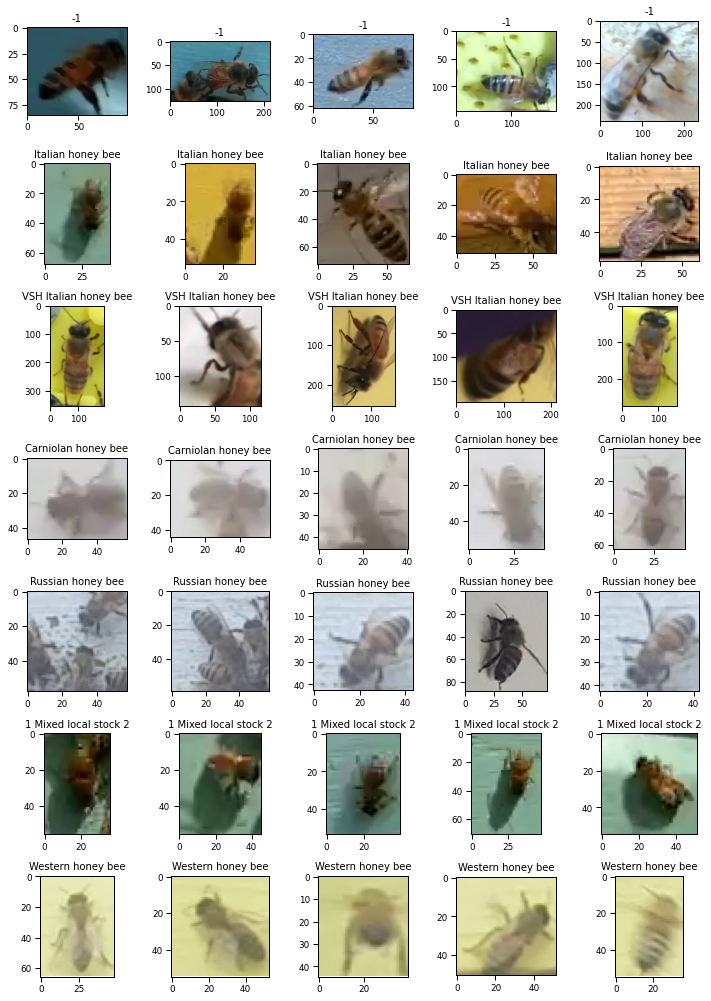

In [10]:
def draw_category_images(data, column, col_length=5):
    '''
    Display bee images by given column

            Parameters:
                    data (dataframe): a dataframe
                    column (str): the name of the column to display
                    col_length (int): the amount of images displayed at each column

            Returns:
                    None
    '''
    categories = data[column].unique()
    fig, ax = plt.subplots(nrows=len(categories), ncols=col_length, figsize=(2*col_length,2*len(categories)))
    
    for i, cat in enumerate(categories):
        sample = data[data[column]==cat].sample(col_length)
        for j in range(col_length):
            file = IMAGES_PATH + sample.iloc[j]['file']
            im = imageio.imread(file)
            ax[i, j].imshow(im, resample=True)
            ax[i, j].set_title(cat, fontsize=10)
    plt.tight_layout()
    plt.show()
    
draw_category_images(bees_df, 'subspecies')

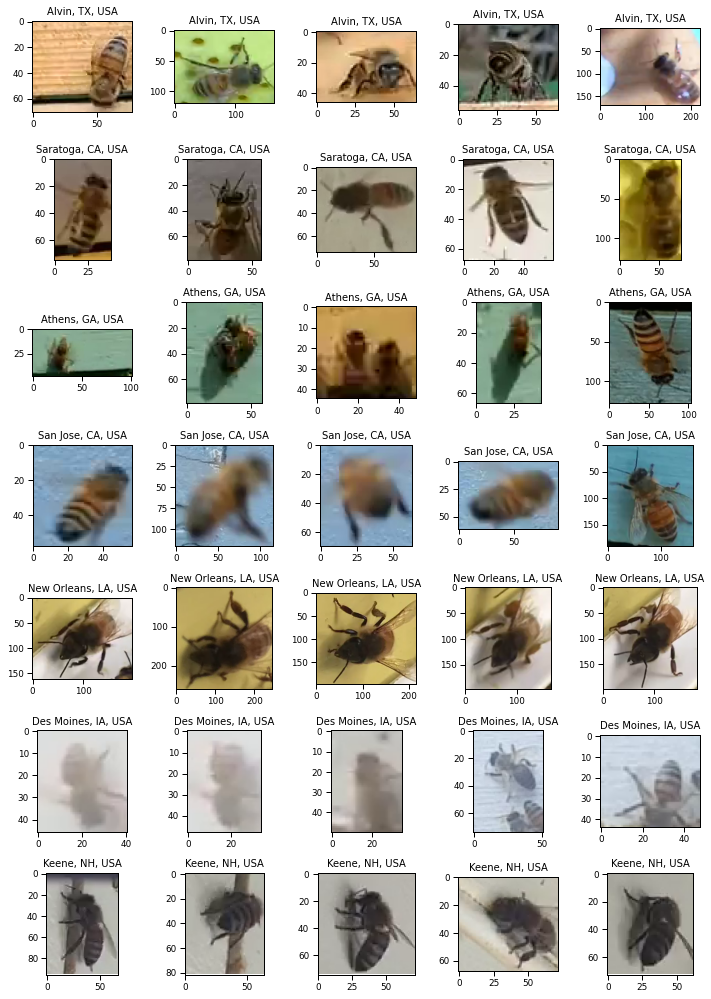

In [11]:
draw_category_images(bees_df, 'location')

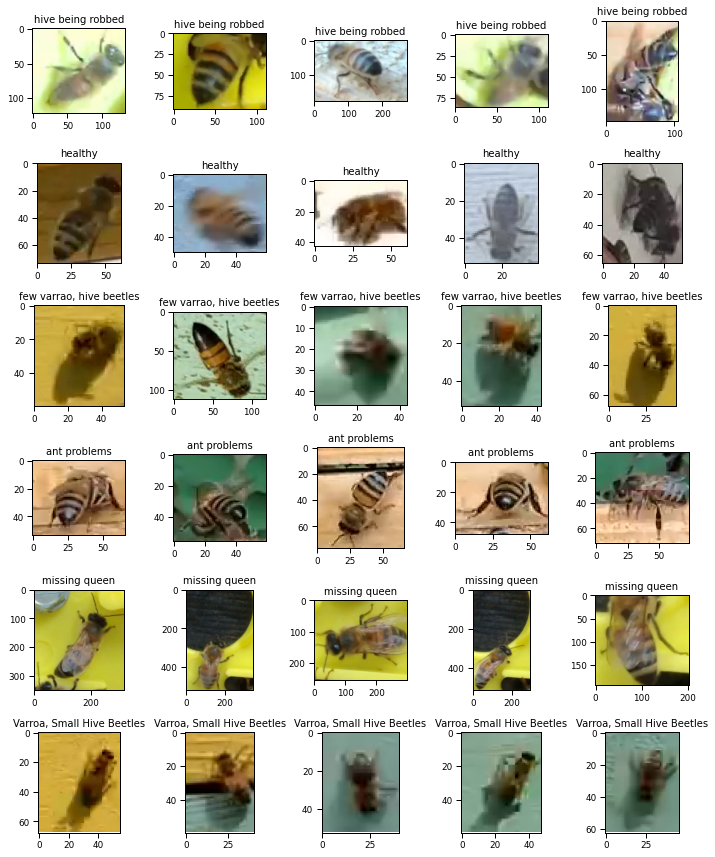

In [12]:
draw_category_images(bees_df, 'health')

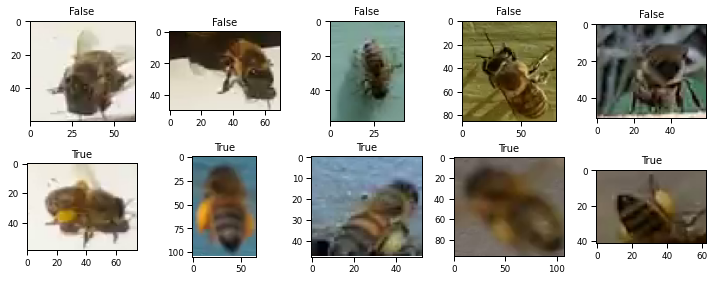

In [13]:
draw_category_images(bees_df, 'pollen_carrying')

The hour or day might correlate to weather the bees are carrying pollen. And the month might correlate to a bee's health. Let's create columns for the different parts of the datetime. 

In [14]:
bees_df['year'] = bees_df['datetime'].dt.year
bees_df['month'] = bees_df['datetime'].dt.month
bees_df['day'] = bees_df['datetime'].dt.day
bees_df['hour'] = bees_df['datetime'].dt.hour
bees_df['minute'] = bees_df['datetime'].dt.minute
bees_df.head()

,datetime,file,location,zip code,subspecies,health,pollen_carrying,caste,year,month,day,hour,minute
0,2018-08-28 16:07:00,041_066.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,2018,8,28,16,7
1,2018-08-28 16:07:00,041_072.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,2018,8,28,16,7
2,2018-08-28 16:07:00,041_073.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,2018,8,28,16,7
3,2018-08-28 16:07:00,041_067.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,2018,8,28,16,7
4,2018-08-28 16:07:00,041_059.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,2018,8,28,16,7


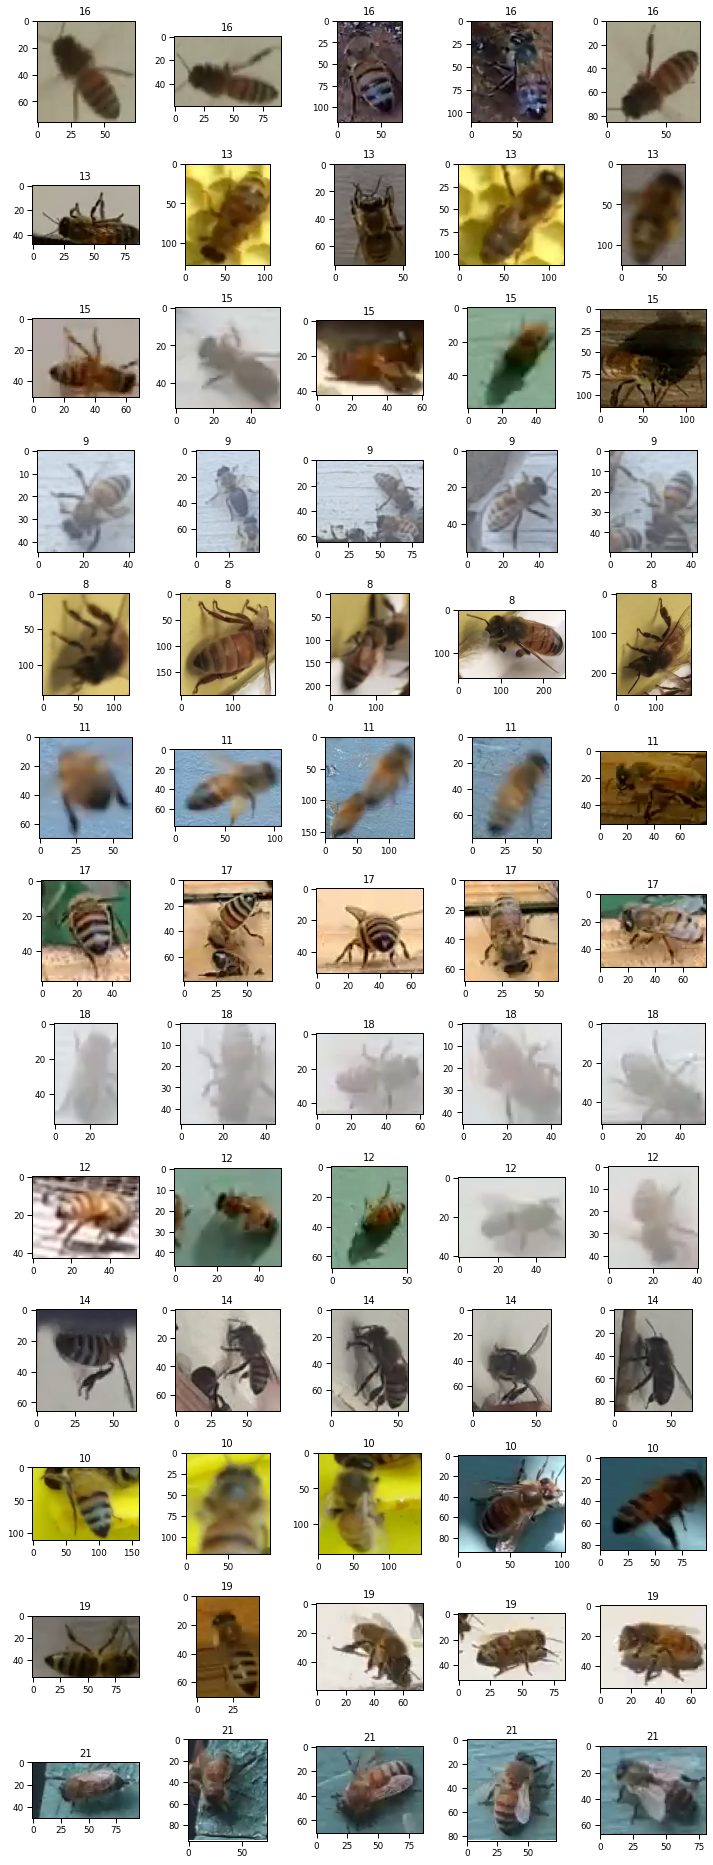

In [15]:
draw_category_images(bees_df, 'hour')

Let's create a correlation map to see if the hour, day, or month correlate to whether the bee is carrying pollen.

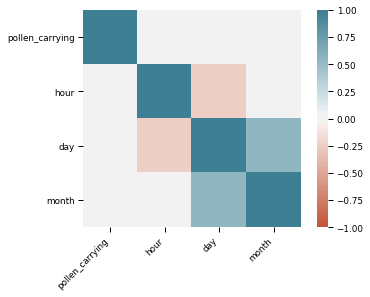

In [16]:
def create_correlation_map(data):
    '''
    Plot a correlation map with given data

            Parameters:
                    data (dataframe): a dataframe

            Returns:
                    None
    '''
    corr = data.corr()
    ax = sns.heatmap(
        corr, 
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    );

create_correlation_map(bees_df[['pollen_carrying', 'hour', 'day', 'month']])

From this map, there seem to be no correlation. 

Let's show the relationship between the subspecies and the location using a heat map.

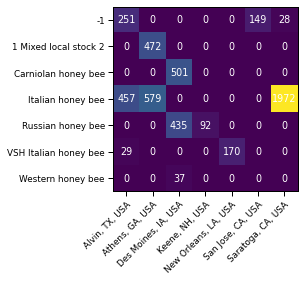

In [17]:
def create_pivot_table(data, col_1, col_2):
    '''
    Creates a pivot table 

            Parameters:
                    data (dataframe): a dataframe
                    col_1 (str): first column of the pivot table
                    col_2 (str): second column of the pivot table

            Returns:
                    (dataframe) : A pivot table
    '''
    return pd.pivot_table(data[[col_1,col_2]], index=[col_1], columns=[col_2], fill_value=0, aggfunc=len)

def create_heat_map(data, col_1, col_2):
    '''
    Creates a heat map 

            Parameters:
                    data (dataframe): a dataframe
                    col_1 (str): first column name 
                    col_2 (str): second column name

            Returns:
                    None
    '''
    piv = create_pivot_table(data, col_1, col_2)
    
    fig, ax = plt.subplots()
    im = ax.imshow(piv.values)
    ax.set_xticks(np.arange(len(piv.values[0])))
    ax.set_yticks(np.arange(len(piv.values)))
    ax.set_xticklabels(piv.columns.values)
    ax.set_yticklabels(piv.index.values)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    for i in range(len(piv)):
        for j in range(len(piv.values[0])):
            text = ax.text(j, i, piv.values[i, j],
                           ha="center", va="center", color="w")

    fig.tight_layout()
    plt.show()

create_heat_map(bees_df, 'subspecies','location')


We see that a bees subspecies and their location are correlated. Let's see if the subspecies and health or correlated. 

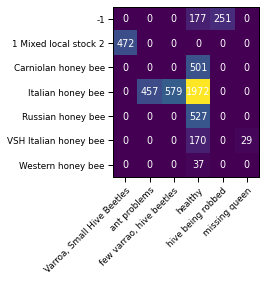

In [18]:
create_heat_map(bees_df, 'subspecies','health')

Let's create a box plot to see if certain bees come at at certain hours or days. 

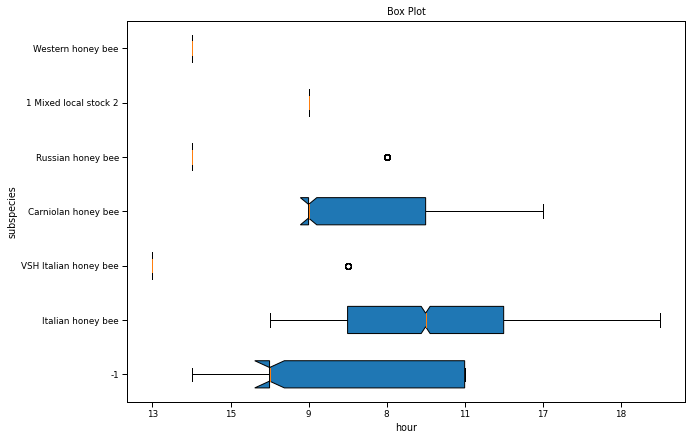

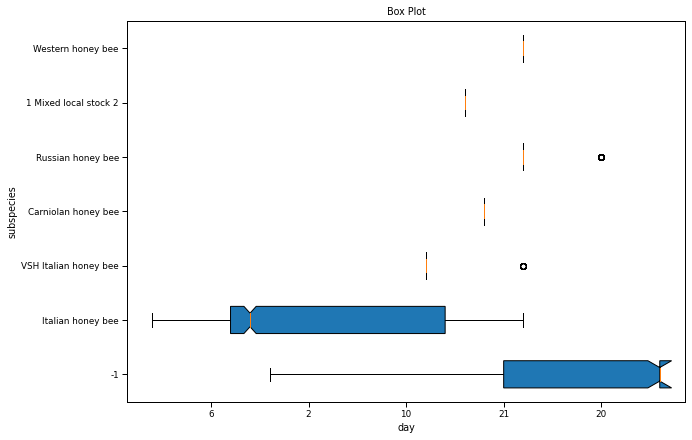

In [19]:
 def create_box_plot(data, col_1, col_2, height=500):
    '''
    Creates a box plot 

            Parameters:
                    data (dataframe): a dataframe
                    col_1 (str): first column name, y values 
                    col_2 (str): second column name, x values

            Returns:
                    None
    '''
    graph_data = list()
    for val in data[col_1].unique():
        graph_data.append(data.loc[data[col_1] == str(val)][col_2])
    
    fig = plt.figure(figsize =(10, 7))

    ax = fig.add_subplot(111)
    bp = ax.boxplot(graph_data, patch_artist = True, 
                    notch ='True', vert = 0) 

    ax.set_title('axes title')
    ax.set_yticklabels(data[col_1].unique())
    ax.set_xticklabels(data[col_2].unique())
    
    ax.set_xlabel(col_2)
    ax.set_ylabel(col_1)

    plt.title('Box Plot') 

    plt.show(bp)

create_box_plot(bees_df, 'subspecies', 'hour')    
create_box_plot(bees_df, 'subspecies', 'day')

# 3. Preparing the data
Before we create the model, we need to prepare it.

Let's split the data into a training set, validation set, and testing set. 

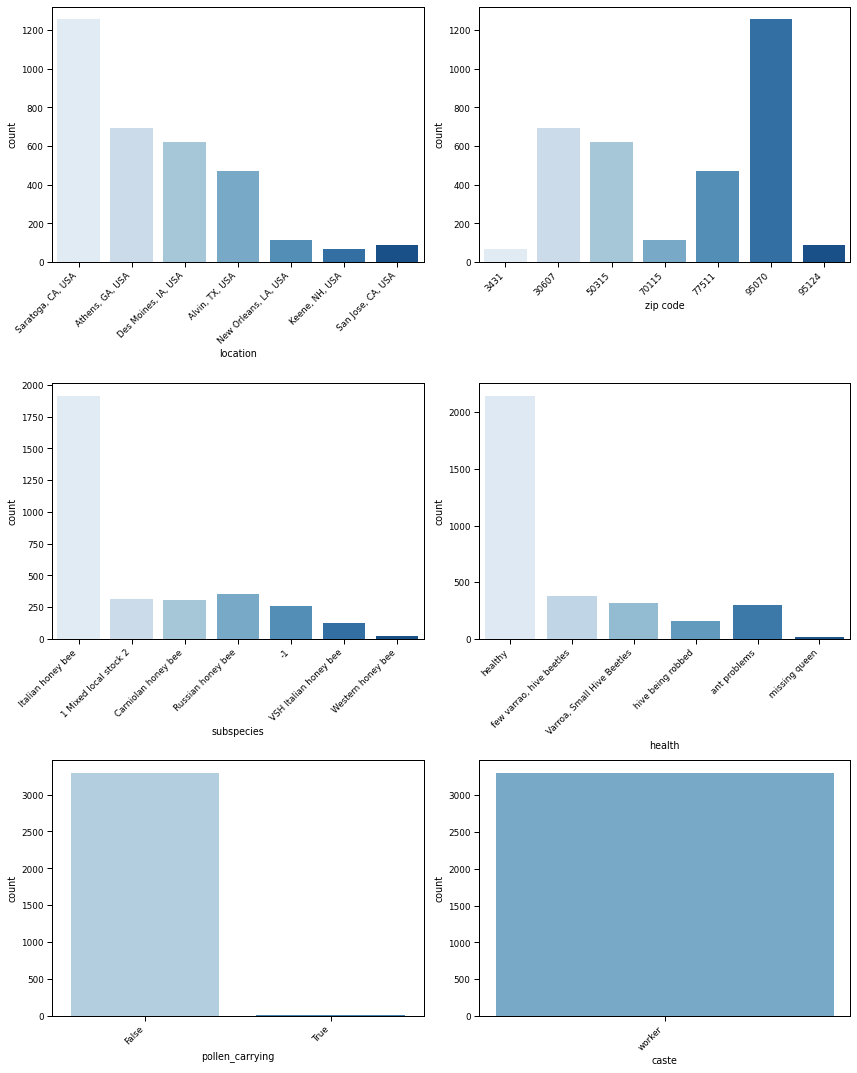

In [20]:
def split_data(data, test_size=.2, val_size=.2):
    '''
    Splits data into a training, validation, and testing dataset

            Parameters:
                    data (dataframe): a dataframe
                    test_size (float): proportion of the data to be the testing data
                    val_size (float): proportion of the training to be the validation data

            Returns:
                    train_df (dataframe) : training data
                    val_df (dataframe) : validation data
                    test_df (dataframe) : testing data
    '''
    train_df, test_df = train_test_split(bees_df, test_size=test_size, random_state=RANDOM_STATE)
    train_df, val_df = train_test_split(train_df, test_size=val_size, random_state=RANDOM_STATE)
    return train_df, val_df, test_df

train_df, val_df, test_df = split_data(bees_df)

plot_value_counts(train_df, ['location', 'zip code', 'subspecies', 'health', 'pollen_carrying','caste'])

Now we need to read and reshape the images. 

In [21]:
def read_image(file_name):
    '''
    Takes a file name and returns a resized image array

            Parameters:
                    file_name (str): the file name

            Returns:
                    image (ndarry): the image array
    '''
    image = skimage.io.imread(IMAGES_PATH + file_name)
    image = skimage.transform.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT), mode='reflect')
    return image[:,:,:IMAGE_CHANNELS]

In [22]:
def prepare_features(dataset, field='subspecies'):
    '''
    Takes a file name and returns a resized image array

            Parameters:
                    dataset (dataframe): the data
                    field (str): the column to use for one-hot encoding

            Returns:
                    X (ndarry): array of images
                    y (DataFrame): Dummy-coded data
    '''
    X = np.stack(dataset['file'].apply(read_image))
    y = pd.get_dummies(dataset[field], drop_first=False)
    return X, y

In [23]:
X_train, y_train = prepare_features(train_df)
X_val, y_val = prepare_features(val_df)
X_test, y_test = prepare_features(test_df)

To deal with the little amount of data we have and to prevent overfitting, we will generator new images to use in our model. 

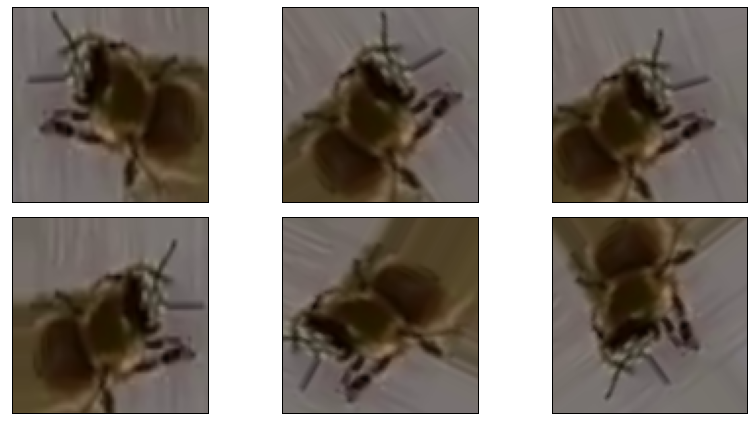

In [24]:
image_generator = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=180,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    #brightness_range=[0.4,1.4],
    )

def display_image_gen(image, generator, num=6):
    '''
    Takes a file name and returns a resized image array

            Parameters:
                    image (ndarray): an image
                    generator (func): image generator function
                    num (int): number of images to display

            Returns:
                    None
    '''
    img1 = np.expand_dims(image, axis=0)
    data_generator = generator.flow(img1,batch_size=1)
    
    plt.figure(figsize=(12,6))
    for i in range(num):
        plt.subplot(num//3,3,i+1)
        for x in data_generator:
            plt.imshow(x[0])
            plt.xticks([])
            plt.yticks([])
            break
    plt.tight_layout()
    plt.show()

display_image_gen(X_train[0], image_generator, 6)


# 4. Creating a base model
Now that we have our data prepared, we will create a base model. We will use dropout to prevent overfitting and speed up training a little. 

In [25]:
model1 = Sequential([
    Conv2D(16, 3, activation="relu", padding="same",
    input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)),
    MaxPool2D(2),
    Dropout(0.5),
    Conv2D(32, 3, activation="relu", padding="same"),
    Dropout(0.5),
    Flatten(),
    Dense(y_train.columns.size, activation="softmax")
])
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 32)        4640      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 80000)             0         
_________________________________________________________________
dense (Dense)                (None, 7)                 5

We will use ealry stoppper to stop when the model is not improving and a check pointer to save the best weights. 

In [26]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

learnratescheduler1 = LearningRateScheduler(scheduler)
earlystopper1 = EarlyStopping(monitor='loss', patience=PATIENCE, verbose=VERBOSE)
checkpointer1 = ModelCheckpoint('best_model_1.h5',
                               monitor='val_accuracy',
                               verbose=1,
                               save_best_only=True,
                               wave_weights_only=True,
                               save_freq='epoch')

history = model1.fit_generator(image_generator.flow(X_train, y_train, batch_size=BATCH_SIZE),
                                   epochs=5,
                                   validation_data=(X_val, y_val),
                                   steps_per_epoch=len(X_train)/BATCH_SIZE,
                                   callbacks=[earlystopper1, checkpointer1, learnratescheduler1])

model1.load_weights('best_model_1.h5')

Epoch 1/5
104/103 [==============================] - ETA: 0s - loss: 1.1869 - accuracy: 0.6274
Epoch 00001: val_accuracy improved from -inf to 0.63768, saving model to best_model_1.h5
104/103 [==============================] - 22s 209ms/step - loss: 1.1869 - accuracy: 0.6274 - val_loss: 0.9247 - val_accuracy: 0.6377
Epoch 2/5
104/103 [==============================] - ETA: 0s - loss: 0.6849 - accuracy: 0.7338
Epoch 00002: val_accuracy improved from 0.63768 to 0.70652, saving model to best_model_1.h5
104/103 [==============================] - 21s 204ms/step - loss: 0.6849 - accuracy: 0.7338 - val_loss: 0.7899 - val_accuracy: 0.7065
Epoch 3/5
104/103 [==============================] - ETA: 0s - loss: 0.5454 - accuracy: 0.7903
Epoch 00003: val_accuracy improved from 0.70652 to 0.78623, saving model to best_model_1.h5
104/103 [==============================] - 21s 206ms/step - loss: 0.5454 - accuracy: 0.7903 - val_loss: 0.5719 - val_accuracy: 0.7862
Epoch 4/5
104/103 [=====================

Let's plot the training history of our model. 

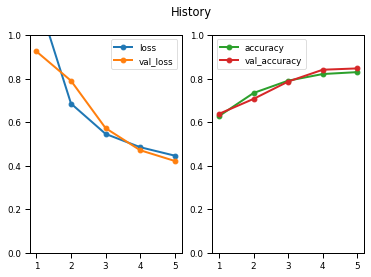

In [27]:
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('History')
    hist_df = pd.DataFrame(history) 
    hist_df['epoch'] = range(1,len(history['loss'])+1)
    ax1.axis(ymin=0,ymax=1)
    ax2.axis(ymin=0,ymax=1)
    ax1.plot( 'epoch', 'loss', data=hist_df, marker='o', color='C0', linewidth=2)
    ax1.plot( 'epoch', 'val_loss', data=hist_df, marker='o', color='C1', linewidth=2)
    ax2.plot( 'epoch', 'accuracy', data=hist_df, marker='o', color='C2', linewidth=2)
    ax2.plot( 'epoch', 'val_accuracy', data=hist_df, marker='o', color='C3', linewidth=2)
    ax1.legend()
    ax2.legend()
    plt.show()

plot_history(history.history)

That looks pretty good. Let's evaluate our model on the test set. 

                       precision    recall  f1-score   support

                   -1       0.95      0.65      0.77        88
1 Mixed local stock 2       0.46      0.66      0.54        80
  Carniolan honey bee       0.97      0.95      0.96       122
    Italian honey bee       0.90      0.89      0.89       606
    Russian honey bee       0.94      0.99      0.96        93
VSH Italian honey bee       0.74      0.62      0.68        42
    Western honey bee       0.50      1.00      0.67         4

             accuracy                           0.86      1035
            macro avg       0.78      0.82      0.78      1035
         weighted avg       0.87      0.86      0.86      1035

Loss: 0.37736567854881287 , Accuracy: 0.8560386300086975


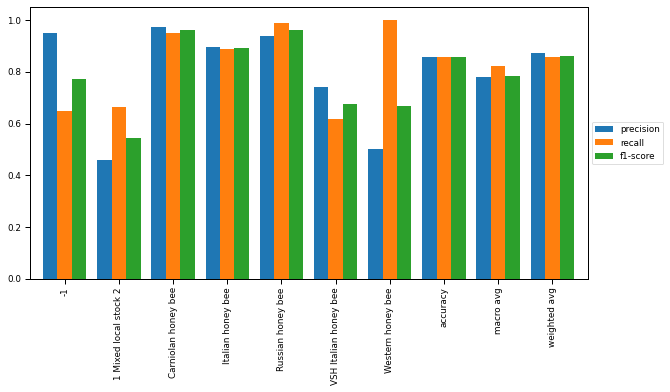

In [28]:
def test_accuracy_report(model, X, y):
    predicted = model.predict(X)
    test_predicted = np.argmax(predicted, axis=1)
    test_truth = np.argmax(y.values, axis=1)
    report = metrics.classification_report(test_truth, test_predicted, target_names=y.columns, output_dict=True)
    print(metrics.classification_report(test_truth, test_predicted, target_names=y.columns))
    test_res = model.evaluate(X, y.values, verbose=0)
    print('Loss:', test_res[0], ', Accuracy:', test_res[1])
    
    df = pd.DataFrame(report).transpose()
    df.drop(['support'], inplace=True, axis=1)
    df.plot(kind='bar', legend=False, width=0.8, figsize=(10,5))
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.show()

test_accuracy_report(model1, X_test, y_test)

Finally, let's save our model. 

In [29]:
# Save the model
model1.save('../output/model1')

# 5. Transfer learning with pretrained models
It takes a lot of time and data to train good models. Let's use transfer learning to create a better model. 

We will be using a pretrained Xception model. The model was pretrained on ImageNet images. To use the CNN, we need to prepare our data. The data needs to be reshaped into a 224 by 244 image, and must go throught a preprocessing function. 

In [30]:
def prepare_images(dataset, field='subspecies'):
    X = np.stack(dataset['file'].apply(preprocess_image))
    y = pd.get_dummies(dataset[field], drop_first=False)
    return X, y

def preprocess_image(file_name): 
    image = skimage.io.imread(IMAGES_PATH + file_name)
    resized_image = tf.image.resize(image, [224, 224])
    final_image = xception.preprocess_input(resized_image)
    return final_image[:,:,:IMAGE_CHANNELS]

X_train, y_train = prepare_images(train_df)
X_val, y_val = prepare_images(val_df)
X_test, y_test = prepare_images(test_df)


After preparing the data, let's create the mdoel. First we need to get the lower layers of the Xception model. Then we add a global average pooling layer, and a Dense layer. 

In [31]:
earlystopper2 = EarlyStopping(monitor='loss', patience=PATIENCE, verbose=VERBOSE)
checkpointer2 = ModelCheckpoint('best_model_2.h5',
                               monitor='val_accuracy',
                               verbose=1,
                               save_best_only=True,
                               wave_weights_only=True,
                               save_freq='epoch')

base_model = xception.Xception(weights="imagenet",
include_top=False)
avg = GlobalAveragePooling2D()(base_model.output)
output = Dense(y_train.columns.size, activation="softmax")(avg)
model2 = Model(inputs=base_model.input, outputs=output)
model2.summary()

83689472/83683744 [==============================] - 1s 0us/step
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
______________________

We freeze the weights of the pretained layers so Gradient Descent does not modify them. 

In [32]:
for layer in base_model.layers:
    layer.trainable = False
    
optimizer = optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model2.compile(loss="categorical_crossentropy",
    optimizer=optimizer,
    metrics=["accuracy"])
history = model2.fit_generator(image_generator.flow(X_train, y_train, batch_size=BATCH_SIZE),
                                   epochs=5,
                                   validation_data=(X_val, y_val),
                                   steps_per_epoch=len(X_train)/BATCH_SIZE,
                                   callbacks=[earlystopper2, checkpointer2])



Epoch 1/5
104/103 [==============================] - ETA: -2s - loss: 3.1342 - accuracy: 0.6890
Epoch 00001: val_accuracy improved from -inf to 0.78744, saving model to best_model_2.h5
104/103 [==============================] - 495s 5s/step - loss: 3.1342 - accuracy: 0.6890 - val_loss: 1.1701 - val_accuracy: 0.7874
Epoch 2/5
104/103 [==============================] - ETA: -2s - loss: 1.1998 - accuracy: 0.8114
Epoch 00002: val_accuracy did not improve from 0.78744
104/103 [==============================] - 489s 5s/step - loss: 1.1998 - accuracy: 0.8114 - val_loss: 1.6616 - val_accuracy: 0.7307
Epoch 3/5
104/103 [==============================] - ETA: -2s - loss: 0.8866 - accuracy: 0.8389
Epoch 00003: val_accuracy improved from 0.78744 to 0.82246, saving model to best_model_2.h5
104/103 [==============================] - 491s 5s/step - loss: 0.8866 - accuracy: 0.8389 - val_loss: 0.8781 - val_accuracy: 0.8225
Epoch 4/5
104/103 [==============================] - ETA: -2s - loss: 0.7215 - a

Now, we unfreeze the weights to see if performance improves. We use a lower learning rate here because we do not want to over tweak the pretrained weights.

In [33]:
for layer in base_model.layers:
    layer.trainable = True
    
optimizer = optimizers.SGD(lr=0.01, momentum=0.9, decay=0.001)
model2.compile(loss="categorical_crossentropy",
    optimizer=optimizer,
    metrics=["accuracy"])
history = model2.fit_generator(image_generator.flow(X_train, y_train, batch_size=BATCH_SIZE),
                                   epochs=5,
                                   validation_data=(X_val, y_val),
                                   steps_per_epoch=len(X_train)/BATCH_SIZE,
                                   callbacks=[earlystopper2, checkpointer2])

model2.load_weights('best_model_2.h5')

Epoch 1/5
104/103 [==============================] - ETA: -9s - loss: 0.4294 - accuracy: 0.8568
Epoch 00001: val_accuracy did not improve from 0.83937
104/103 [==============================] - 1822s 18s/step - loss: 0.4294 - accuracy: 0.8568 - val_loss: 0.9988 - val_accuracy: 0.7657
Epoch 2/5
104/103 [==============================] - ETA: -9s - loss: 0.1600 - accuracy: 0.9447
Epoch 00002: val_accuracy improved from 0.83937 to 0.93357, saving model to best_model_2.h5
104/103 [==============================] - 1831s 18s/step - loss: 0.1600 - accuracy: 0.9447 - val_loss: 0.2196 - val_accuracy: 0.9336
Epoch 3/5
104/103 [==============================] - ETA: -9s - loss: 0.1267 - accuracy: 0.9507
Epoch 00003: val_accuracy improved from 0.93357 to 0.96135, saving model to best_model_2.h5
104/103 [==============================] - 1806s 17s/step - loss: 0.1267 - accuracy: 0.9507 - val_loss: 0.1294 - val_accuracy: 0.9614
Epoch 4/5
104/103 [==============================] - ETA: -9s - loss: 0

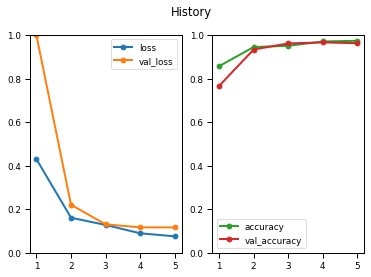

In [34]:
plot_history(history.history)

                       precision    recall  f1-score   support

                   -1       0.95      0.95      0.95        88
1 Mixed local stock 2       0.79      0.91      0.85        80
  Carniolan honey bee       0.98      0.99      0.99       122
    Italian honey bee       0.98      0.96      0.97       606
    Russian honey bee       0.98      1.00      0.99        93
VSH Italian honey bee       1.00      0.90      0.95        42
    Western honey bee       1.00      0.75      0.86         4

             accuracy                           0.96      1035
            macro avg       0.96      0.93      0.94      1035
         weighted avg       0.96      0.96      0.96      1035

Loss: 0.11702319979667664 , Accuracy: 0.9623188376426697


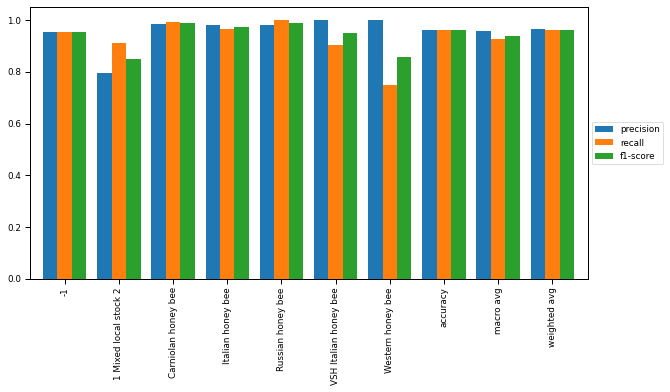

In [35]:
test_accuracy_report(model2, X_test, y_test)

In [36]:
model2.save('../output/model2')

# 6. Classify Bee's Health
Now that we create a good model to classify bees by their subspecies, let's use the same techniques to classify bees by their health. 

In [37]:
X_train, y_train = prepare_images(train_df, 'health')
X_val, y_val = prepare_images(val_df, 'health')
X_test, y_test = prepare_images(test_df, 'health')

In [38]:
earlystopper3 = EarlyStopping(monitor='loss', patience=PATIENCE, verbose=VERBOSE)
checkpointer3 = ModelCheckpoint('best_model_3.h5',
                               monitor='val_accuracy',
                               verbose=1,
                               save_best_only=True,
                               wave_weights_only=True,
                               save_freq='epoch')

base_model = xception.Xception(weights="imagenet",
include_top=False)
avg = GlobalAveragePooling2D()(base_model.output)
output = Dense(y_train.columns.size, activation="softmax")(avg)
model3 = Model(inputs=base_model.input, outputs=output)
model3.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

In [39]:
for layer in base_model.layers:
    layer.trainable = False
    
optimizer = optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model3.compile(loss="categorical_crossentropy",
    optimizer=optimizer,
    metrics=["accuracy"])
history = model3.fit_generator(image_generator.flow(X_train, y_train, batch_size=BATCH_SIZE),
                                   epochs=5,
                                   validation_data=(X_val, y_val),
                                   steps_per_epoch=len(X_train)/BATCH_SIZE,
                                   callbacks=[earlystopper3, checkpointer3])

Epoch 1/5
104/103 [==============================] - ETA: -2s - loss: 3.0263 - accuracy: 0.7032
Epoch 00001: val_accuracy improved from -inf to 0.78623, saving model to best_model_3.h5
104/103 [==============================] - 479s 5s/step - loss: 3.0263 - accuracy: 0.7032 - val_loss: 1.4790 - val_accuracy: 0.7862
Epoch 2/5
104/103 [==============================] - ETA: -2s - loss: 1.1901 - accuracy: 0.8241
Epoch 00002: val_accuracy did not improve from 0.78623
104/103 [==============================] - 484s 5s/step - loss: 1.1901 - accuracy: 0.8241 - val_loss: 1.1971 - val_accuracy: 0.7778
Epoch 3/5
104/103 [==============================] - ETA: -2s - loss: 0.7873 - accuracy: 0.8495
Epoch 00003: val_accuracy improved from 0.78623 to 0.85266, saving model to best_model_3.h5
104/103 [==============================] - 487s 5s/step - loss: 0.7873 - accuracy: 0.8495 - val_loss: 0.8162 - val_accuracy: 0.8527
Epoch 4/5
104/103 [==============================] - ETA: -2s - loss: 0.6177 - a

In [40]:
for layer in base_model.layers:
    layer.trainable = True
    
optimizer = optimizers.SGD(lr=0.01, momentum=0.9, decay=0.001)
model3.compile(loss="categorical_crossentropy",
    optimizer=optimizer,
    metrics=["accuracy"])
history = model3.fit_generator(image_generator.flow(X_train, y_train, batch_size=BATCH_SIZE),
                                   epochs=5,
                                   validation_data=(X_val, y_val),
                                   steps_per_epoch=len(X_train)/BATCH_SIZE,
                                   callbacks=[earlystopper3, checkpointer3])

model3.load_weights('best_model_3.h5')

Epoch 1/5
104/103 [==============================] - ETA: -9s - loss: 0.3789 - accuracy: 0.8682
Epoch 00001: val_accuracy improved from 0.85870 to 0.90217, saving model to best_model_3.h5
104/103 [==============================] - 1815s 17s/step - loss: 0.3789 - accuracy: 0.8682 - val_loss: 0.2886 - val_accuracy: 0.9022
Epoch 2/5
104/103 [==============================] - ETA: -9s - loss: 0.1419 - accuracy: 0.9495
Epoch 00002: val_accuracy improved from 0.90217 to 0.93116, saving model to best_model_3.h5
104/103 [==============================] - 1805s 17s/step - loss: 0.1419 - accuracy: 0.9495 - val_loss: 0.1852 - val_accuracy: 0.9312
Epoch 3/5
104/103 [==============================] - ETA: -9s - loss: 0.1067 - accuracy: 0.9616
Epoch 00003: val_accuracy improved from 0.93116 to 0.96135, saving model to best_model_3.h5
104/103 [==============================] - 1814s 17s/step - loss: 0.1067 - accuracy: 0.9616 - val_loss: 0.1087 - val_accuracy: 0.9614
Epoch 4/5
104/103 [===============

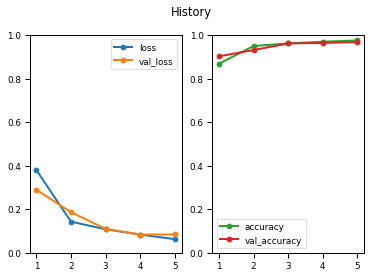

In [41]:
plot_history(history.history)

                            precision    recall  f1-score   support

Varroa, Small Hive Beetles       0.78      0.96      0.86        80
              ant problems       1.00      0.99      0.99        96
  few varrao, hive beetles       0.95      0.78      0.86       108
                   healthy       1.00      1.00      1.00       697
         hive being robbed       0.96      1.00      0.98        47
             missing queen       1.00      0.86      0.92         7

                  accuracy                           0.97      1035
                 macro avg       0.95      0.93      0.94      1035
              weighted avg       0.97      0.97      0.97      1035

Loss: 0.09987229853868484 , Accuracy: 0.9710144996643066


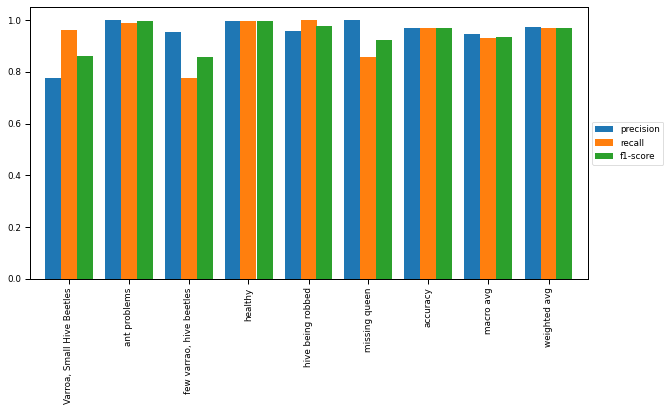

In [42]:
test_accuracy_report(model3, X_test, y_test)

In [43]:
model3.save('../output/model3')

# References
* [1] Gabriel Preda, Honey Bee Subspecies Classification https://www.kaggle.com/gpreda/honey-bee-subspecies-classification/output
* [2] Dmitry Pukhov, Honey Bee health detection with CNN, https://www.kaggle.com/dmitrypukhov/honey-bee-health-detection-with-cnn
* [3] Aurelien Geron, Hands-On Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems